In [2]:
# import the dataset from Sklearn
import pandas as pd
from sklearn.datasets import load_breast_cancer

# Read the DataFrame, first using the feature data
data = load_breast_cancer() 
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add a target column, and fill it with the target data
df['target'] = data.target

# Show the first five rows
df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  target  
0          0.4601                  0.11890       0  
1          0.2750                  0.08902       0  
2          0.3613                  0.08758       0  
3          0.6638                  0.17300       0  
4          0.2364                  0.07678       0  

[5 rows x 31 columns]

In [3]:
# setting up data for modelling
y = df['target'].to_frame()
X = df[df.columns.difference(['target'])]

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)

In [11]:
#build model - Xgboost
import xgboost as xgb
xgb_mod = xgb.XGBClassifier(random_state=42, gpu_id=0)
xgb_mod = xgb_mod.fit(X_train, y_train.values.ravel())

[12:31:14] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


In [12]:
#predictions
y_pred = xgb_mod.predict(X_test)

In [14]:
#performance
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy *100.0))

Accuracy: 97.37%


# SHAP

In [17]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.8 MB/s eta 0:00:00


In [18]:
import shap

In [19]:
# generate the Tree explainer and SHAP values
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


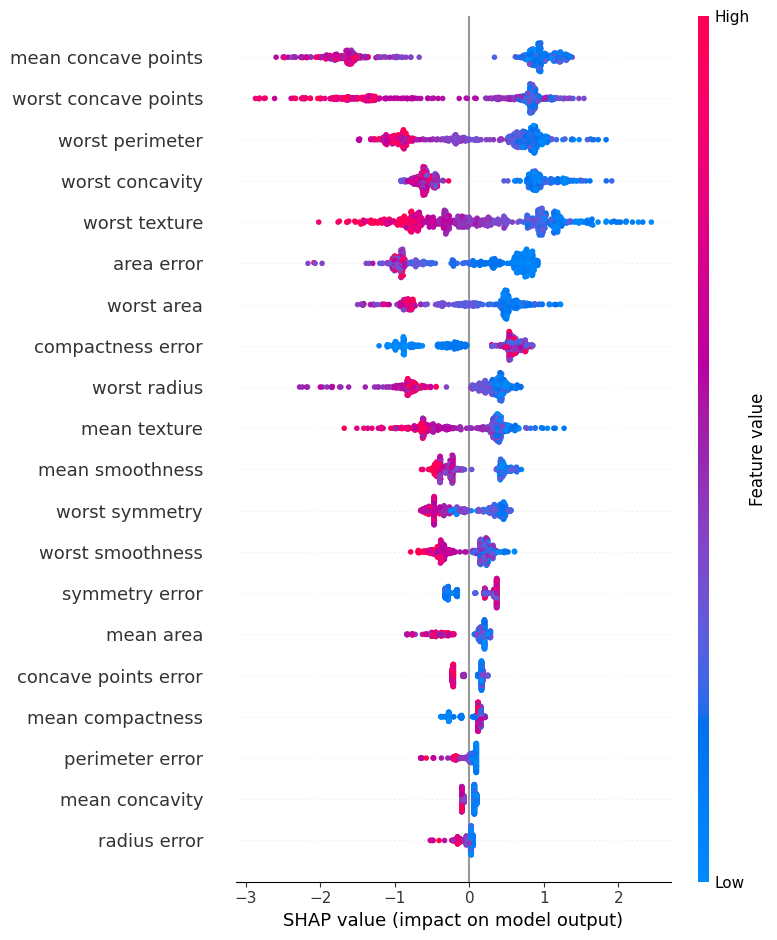

In [20]:
### visualizations ###
shap.summary_plot(shap_values, X, title = "SHAP summary plot")

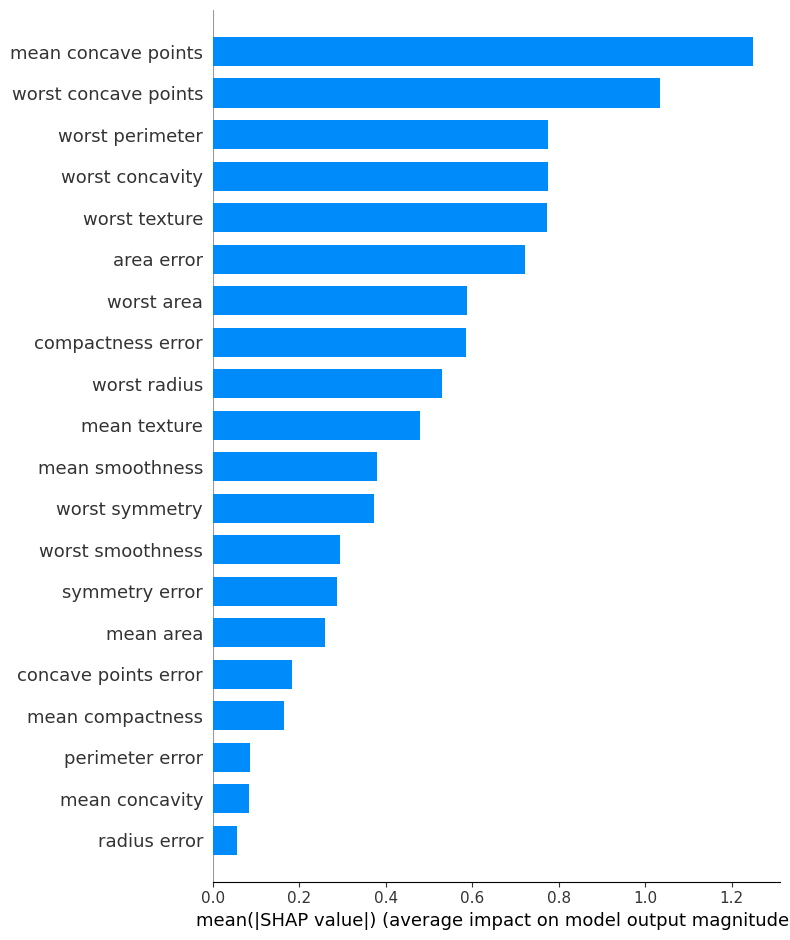

In [21]:
#summary bar plot
shap.summary_plot(shap_values, X, plot_type="bar")

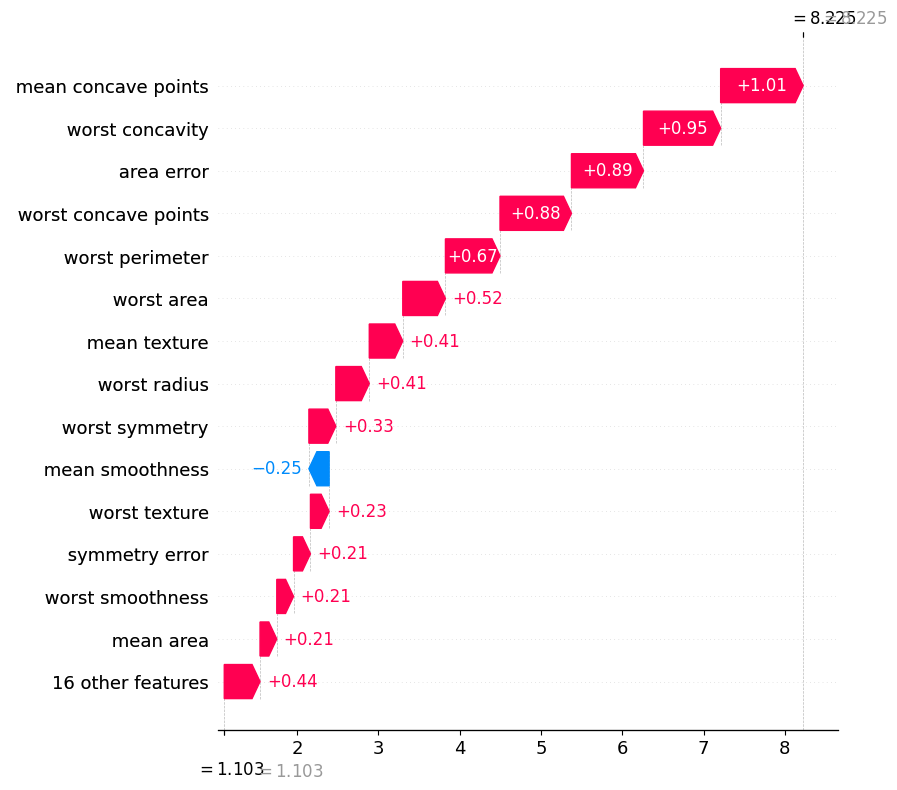

In [24]:
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[79], features = X.loc[79,:], feature_names=X.columns, max_display=15, show=True)

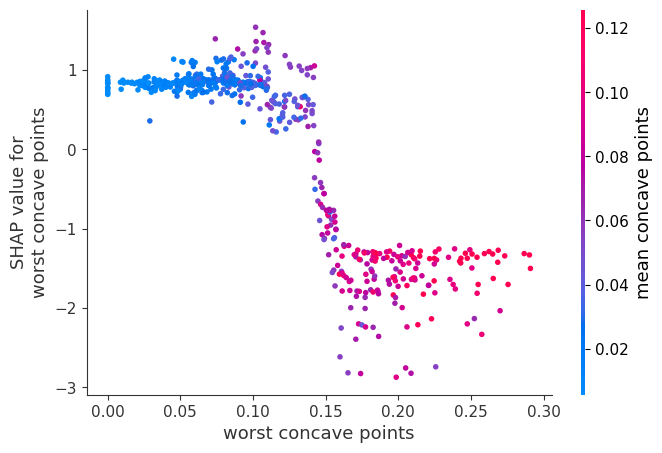

In [25]:
# dependency plot
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")

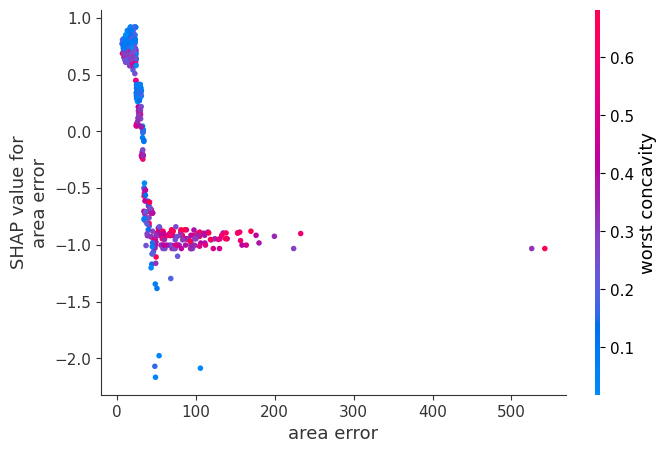

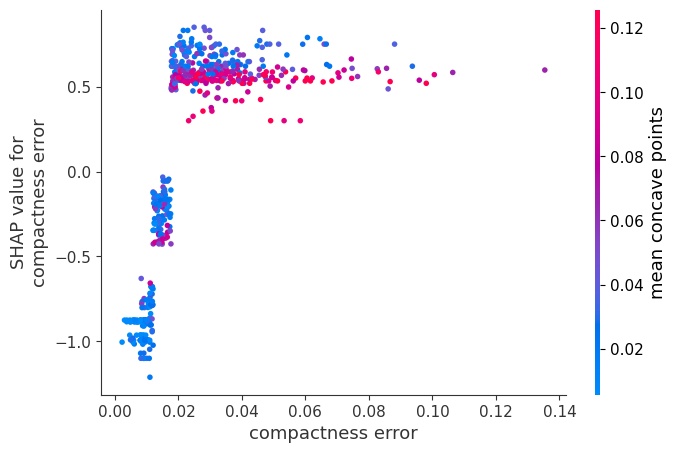

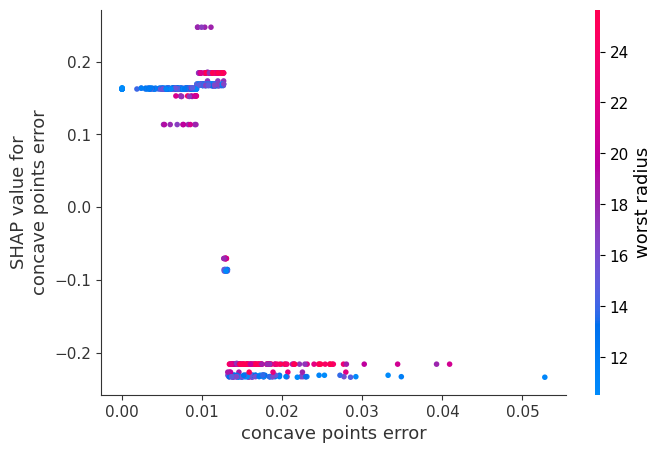

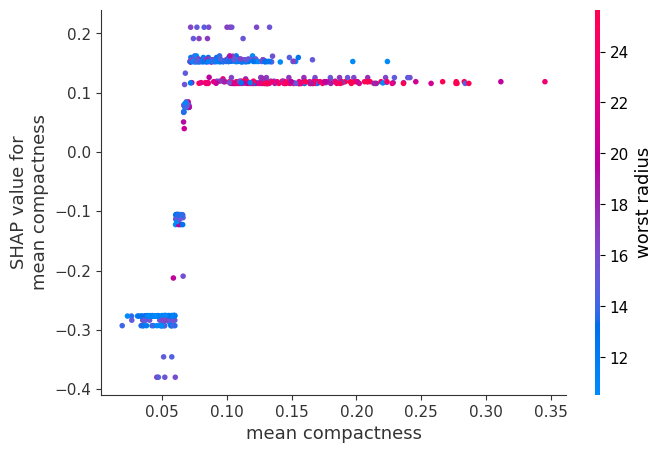

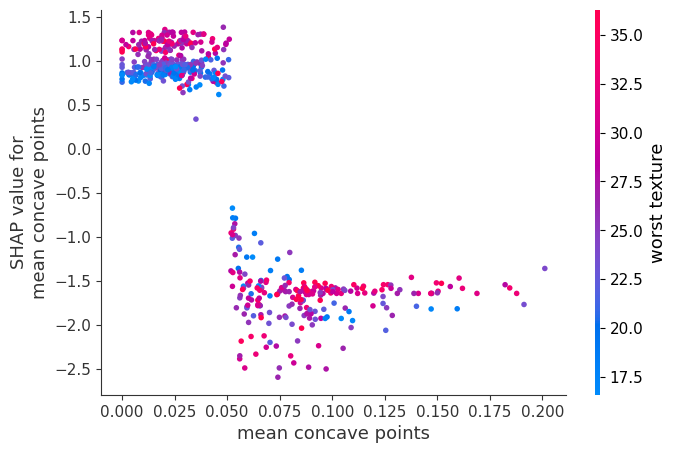

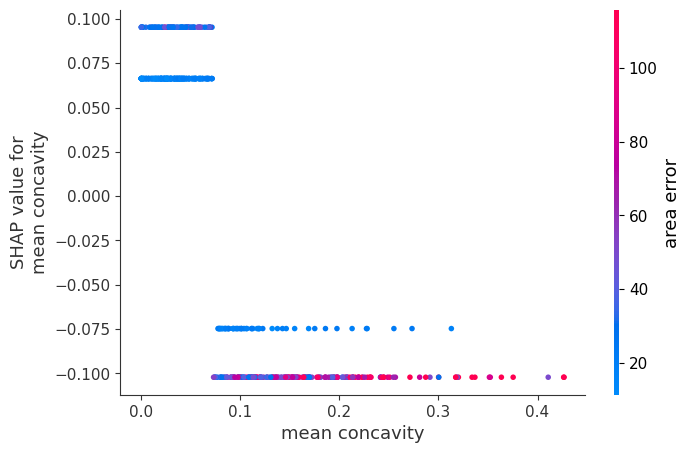

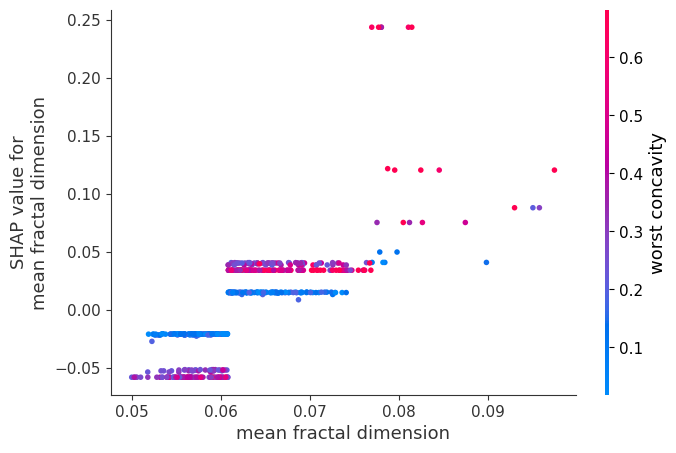

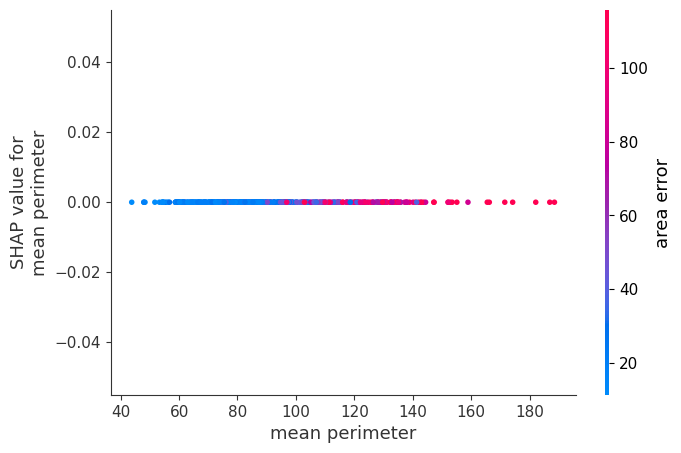

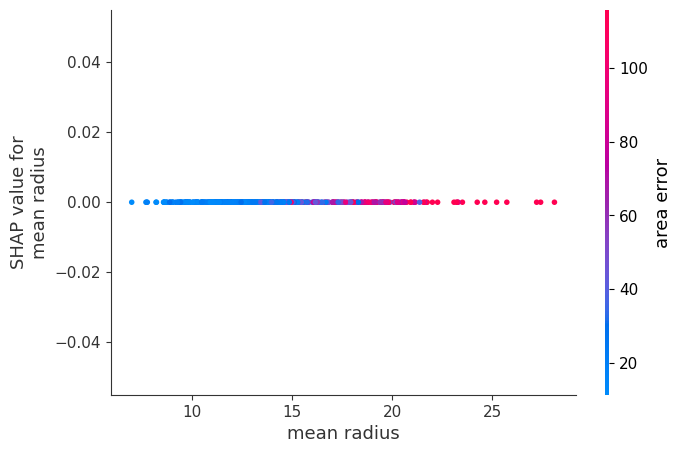

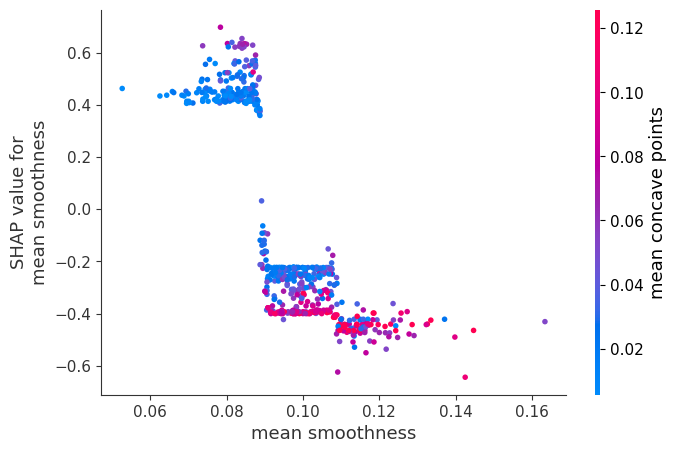

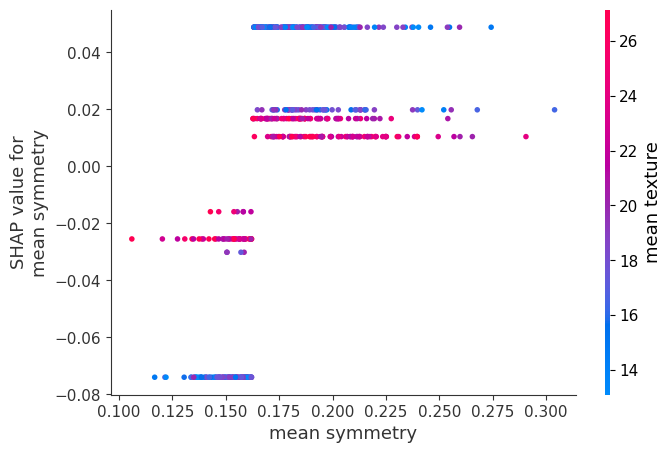

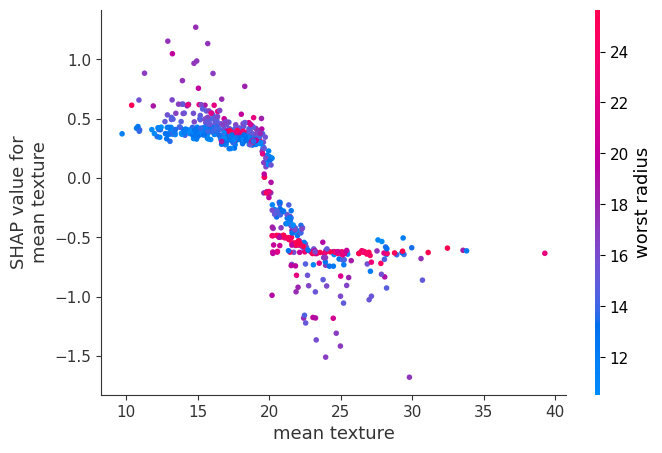

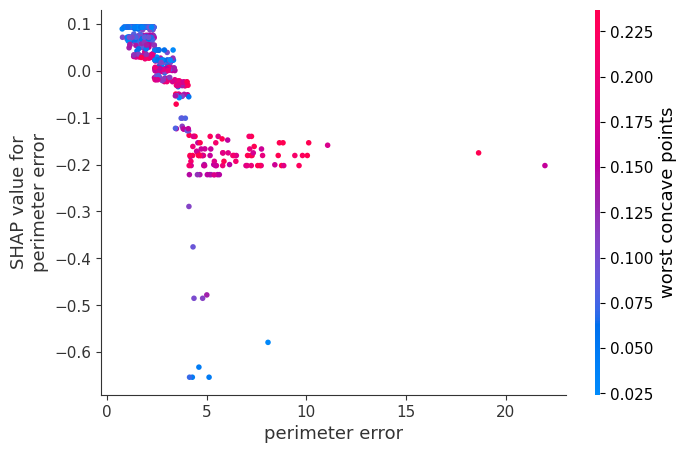

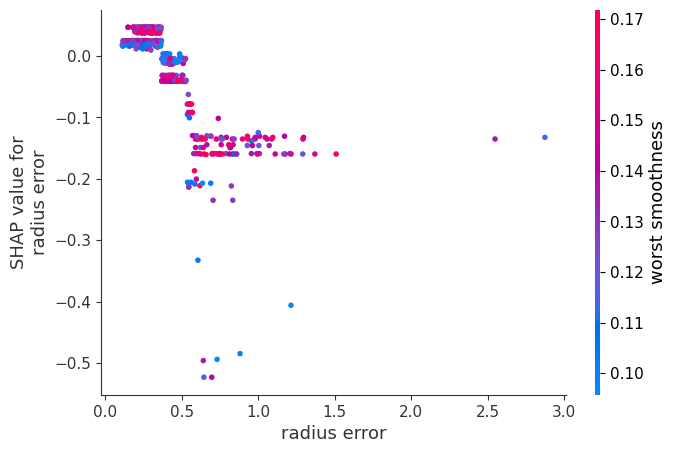

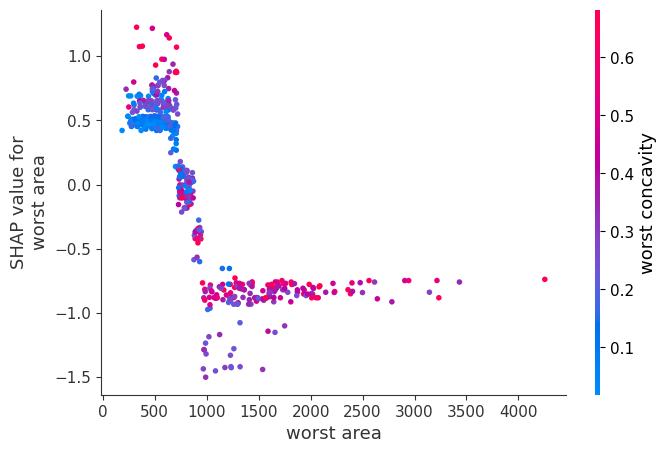

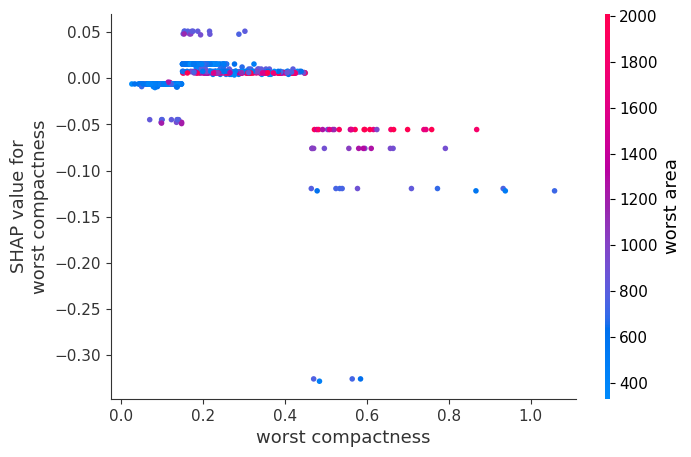

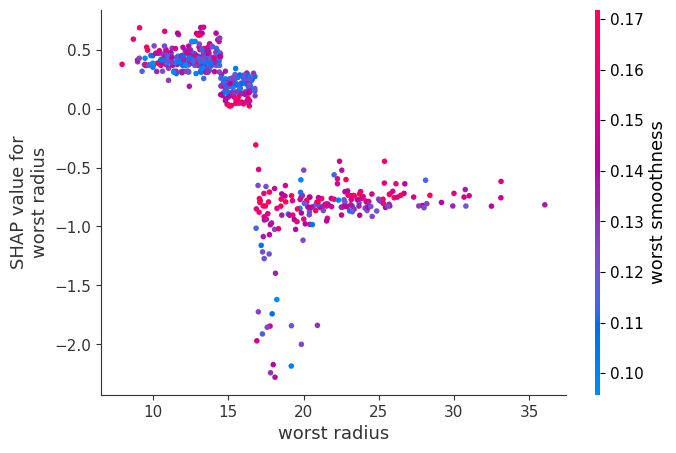

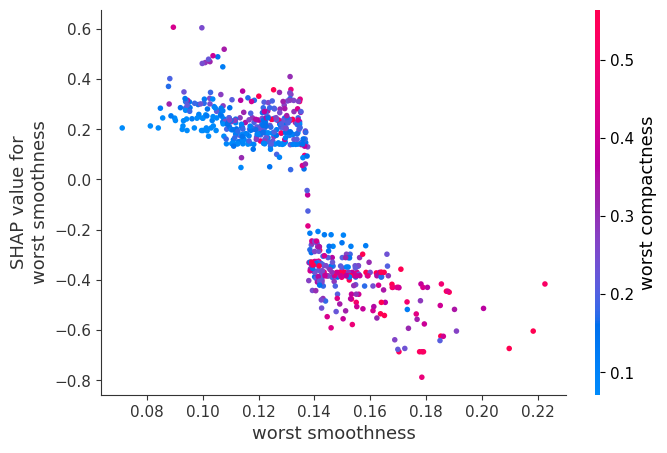

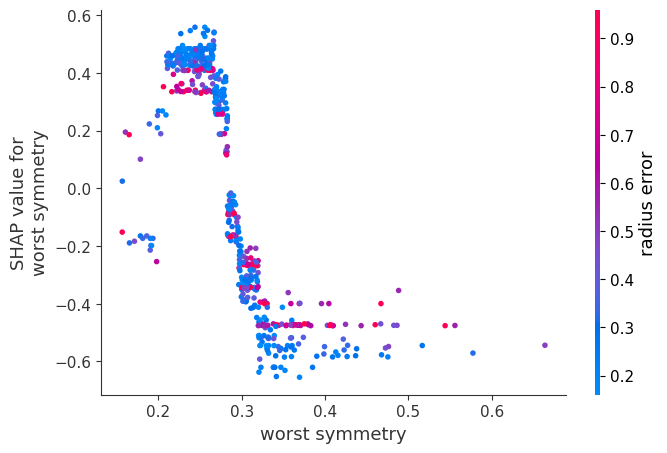

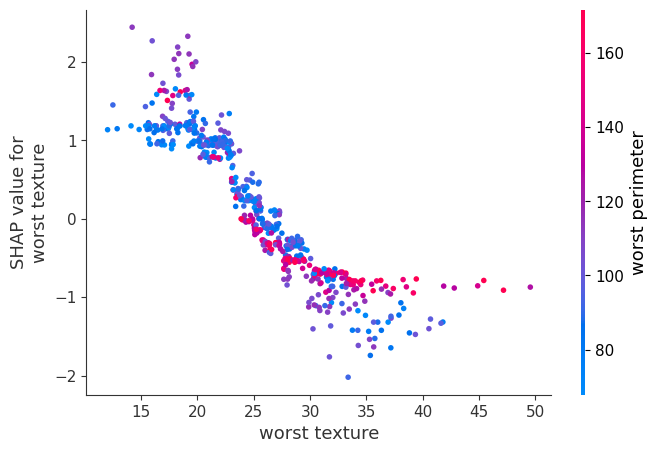

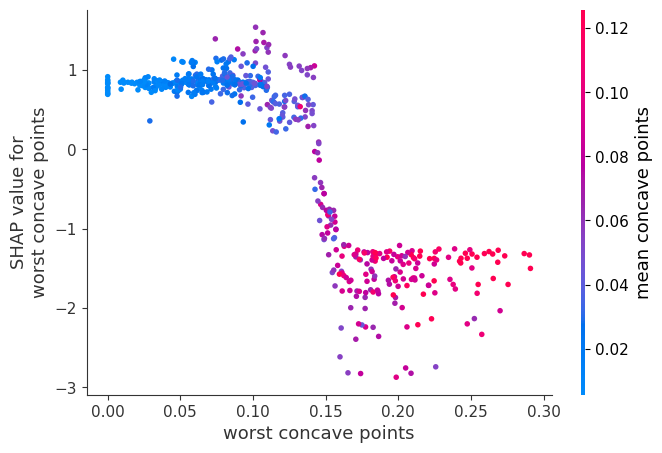

In [30]:
# generate multiple dependece plots
for name in X_train.columns:
     shap.dependence_plot(name, shap_values, X)
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")

In [32]:
# generate force plot - multiple rows
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100, :], X.iloc[:100,:])

In [33]:
# generate force plot - single
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

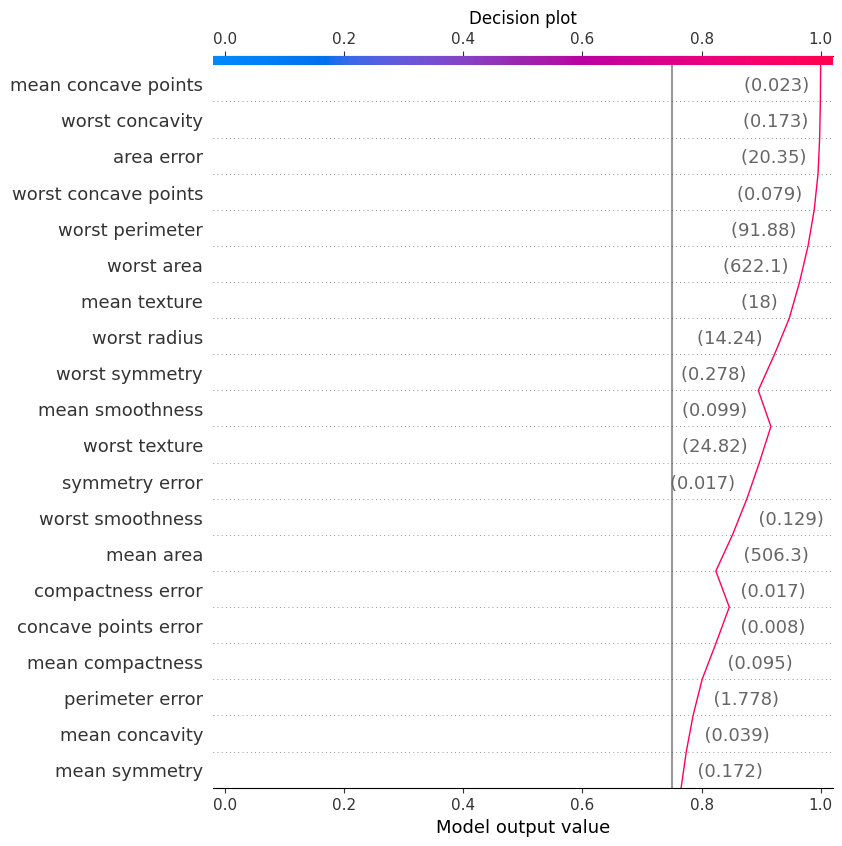

In [34]:
# generate decision plot
shap.initjs()
shap.decision_plot(expected_value, shap_values[79], link='logit', features=X.loc[79, :], feature_names=(X.columns.tolist()), show=True, title="Decision plot")

# LIME

In [36]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=ea5a0dacd94717654d62b3a0c2cc14304088f1cf79da7dac74d511be92576410
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [37]:
import lime
import lime.lime_tabular
import numpy as np
import xgboost

In [39]:
## creating explainer ##
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.to_numpy(), feature_names=X_test.columns, class_names=['0','1'], verbose=True)

In [41]:
## visualizations ##
exp = explainer.explain_instance(X_test.to_numpy()[79], xgb_mod.predict_proba, num_features =20)
exp.show_in_notebook(show_table=True)

Intercept 0.42463247510052327
Prediction_local [1.20535426]
Right: 0.99759597


# Shapash

In [43]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.3 MB/s eta 0:00:00


In [45]:
!pip install shapash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.7/652.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.7/642.7 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dash-renderer: filename=dash_renderer-1.8.3-py3-none-any.whl size=1013934 sha256=a23cea0fbae1821b7f0a37ac5afcad5e6ba0443fb5c90828bf39a771f22f0387
  Stored in directory: /root/.cache/pip/wheels/6c/04/c8/22a0b5a26c3ecb61e17a27d4bbe7fad32d1417bbdbd4d46acf
  Created wheel for dash-daq: filename=dash_daq-0.5.0-py3-none-any.whl size=669714 sha256=d21acc058db6da897a36a496531c7d2e74b0b7d75ab0aa7d9c186

In [51]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [55]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
import shapash
#import data_table as dt 
from sklearn.metrics import f1_score, confusion_matrix
from shapash.utils.load_smartpredictor import load_smartpredictor
from shapash.explainer.smart_explainer import SmartExplainer

In [57]:
# create explainer
xpl = SmartExplainer(model=xgb_mod)
xpl.compile(x=X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [59]:
# creating application
app = xpl.run_app(title_story="Breast Cancer")

Dash is running on http://0.0.0.0:8050/



INFO:dash.dash:Dash is running on http://0.0.0.0:8050/



 * Serving Flask app 'shapash.webapp.smart_app'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8050
 * Running on http://172.28.0.12:8050
INFO:werkzeug:Press CTRL+C to quit


In [60]:
# feature importance based on SHAP
xpl.plot.features_importance()

In [61]:
#contributions plot
xpl.plot.contribution_plot("worst concave points")

In [62]:
# local explanation
xpl.plot.local_plot(index=79)

In [63]:
#compare plot
xpl.plot.compare_plot(index=[X_test.index[79], X_test.index[80]])

In [66]:
#interactive interactions widget
xpl.plot.top_interactions_plot()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [65]:
#save contributions
predictor = xpl.to_smartpredictor()
predictor.add_input(x=X_train, ypred=y_train)
detailed_contributions = predictor.detail_contributions()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

